# DMC for the Hydrogen Atom

## General definitions and imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D

In [2]:
def plot_position(pos_vector,alive):
    """Return 3D plot of the walker positions, based on the 6D position vector
    
    Parameters:
    -----------
    pos_vector: numpy array
        An array containing position of the walkers at a certain timestep
    alive: boolean array
        An array which contains booleans corresponding to the walkers. Element is 
        True when walker is alive.
    
    Returns:
    -----------
    plot
         3D plot with position of all living walkers

    """
    k = 0
    x = np.zeros((alive.count(True),6))
    
    #Only take walkers which are alive
    for i in range(np.shape(pos_vector)[0]):
        if alive[i]:
            x[k,:] = pos_vector[i,:]
            k +=1
    
    #Create the 3D scatter plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x[:,0],x[:,1],x[:,2])
    ax.scatter(x[:,3],x[:,4],x[:,5])
    L=2
    ax.set_xlim3d([-2*L,2*L])
    ax.set_ylim3d([-L,L])
    ax.set_zlim3d([-L,L]) 

In [3]:
def data_blocking(datavector, l):
    """Calculate the average and standard deviation 
    of the physical input data using data_blocking,
    
    Parameters:
    -----------
    datavector: array
        The 1D - array containing the data at each timestep
    l: int
       Block length to be used with data blocking
    
    Returns:
    -----------
    tuple of floats
         Average and standard deviation of the data

    """
    
    #Divide the datavector in blocks
    blocks = [datavector[i:i+l] for i in range(0, len(datavector), l)]
    
    #Remove the last block (with probably different length)
    blocks = blocks[:-1] 
    
    mean_array = [np.mean(A) for A in blocks]
    mean_sqd = [A**2 for A in mean_array]
    mean = np.mean(mean_array)
    
    std = np.sqrt(np.mean(mean_sqd) - mean**2)
    
    return mean, std

In [4]:
#This block is needed to create homogeneous plots throughout the project
fparams = {'axes.labelsize': 22,
           'axes.titlesize': 25,
           'axes.linewidth': 1.5,
           'font.size': 16,
           'legend.fontsize': 20,
           'font.family': 'serif',
           'font.serif': 'Computer Modern Roman',
           'xtick.labelsize': 15,
           'xtick.major.size': 5.5,
           'xtick.major.width': 1.5,
           'ytick.labelsize': 15,
           'ytick.major.size': 5.5,
           'ytick.major.width': 1.5,
           'text.usetex': True,
           'figure.autolayout': True}
plt.rcParams.update(fparams)

## Definitions related to Hydrogen Molecule

In [5]:
def find_a(s):
    """Calculate wave function parameter 'a' using Coulomb cusp condition.
    
    Parameters:
    ----------- 
    s: float
       Distance between the protons
        
    Returns:
    -----------
    float
         Value of parameter a
    """
    
    #Define the function f which should equal to zero (Coulomb cusp condition)
    def f(a,s):
        return a * (1 + np.exp(-s/a)) - 1
    
    #Find the a which satisfies equation f = 0
    a = optimize.fsolve(f, 0.75, args = (s))
    
    return a

In [6]:
def Calculate_F_p_and_V(Pos_walkers,s,a,beta):
    """Calculate force on the walker, wavefunction squared of the walker and 
    potential energy of the walker.
    
    
    Parameters:
    -----------
    Pos_walkers: numpy array
        Array containing the position of all walkers 
    s: float
        Wavefunction parameter (seperation protons)   
    a: float
        Wavefunction parameters trial Wavefunction
    beta: float
        Wavefunction parameter
           
    Returns: 
    ----------- 
    tuple of numpy arrays
        An array with force for each walker 
        An array with potential energy at position of each walker 
        An array with wavefunction squared at position of each walker 
    
    """
   
    #Define arrays to store Force and Potential energy
    F = np.zeros((6))
    V = np.zeros((1))
    
    #Frequently used array in calculations
    Add_s = np.array([1, 0, 0])
    
    #Calculate some frequently used terms
    r1L = Pos_walkers[0:3] + s * 0.5 * Add_s
    r1L_norm = np.linalg.norm(r1L, axis=0)
    r1R = Pos_walkers[0:3] - s * 0.5 * Add_s
    r1R_norm = np.linalg.norm(r1R, axis=0)
    r2L = Pos_walkers[3:6] + s * 0.5 * Add_s
    r2L_norm = np.linalg.norm(r2L, axis=0)
    r2R = Pos_walkers[3:6] - s * 0.5 * Add_s
    r2R_norm = np.linalg.norm(r2R, axis=0)
    r12 = Pos_walkers[0:3] - Pos_walkers[3:6]
    r12_norm = np.linalg.norm(r12, axis=0)

    phi1L = np.exp(-r1L_norm / a)
    phi1R = np.exp(-r1R_norm / a)
    phi1 = phi1L + phi1R
    phi2L = np.exp(-r2L_norm / a)
    phi2R = np.exp(-r2R_norm / a)
    phi2 = phi2L + phi2R
    r1Lr12 = np.sum(r1L * r12, axis=0)/(r1L_norm * r12_norm)
    r1Rr12 = np.sum(r1R * r12, axis=0)/(r1R_norm * r12_norm)
    r2Lr12 = np.sum(r2L * r12, axis=0)/(r2L_norm * r12_norm)
    r2Rr12 = np.sum(r2R * r12, axis=0)/(r2R_norm * r12_norm)

    
    #Calculate force and local energy, remember that the parameter alpha = 2
    F[0:3] = -2/(a*phi1) * (phi1L*r1L/r1L_norm + phi1R*r1R/r1R_norm) + \
            r12/r12_norm*(1+beta*r12_norm)**-2
    F[3:6] = -2/(a*phi2) * (phi2L*r2L/r2L_norm + phi2R*r2R/r2R_norm) + \
            -r12/r12_norm*(1+beta*r12_norm)**-2
    V = -a**(-2) + \
        a**(-1) * phi1**(-1) * (phi1L/r1L_norm + phi1R/r1R_norm) + \
        a**(-1) * phi2**(-1) * (phi2L/r2L_norm + phi2R/r2R_norm) + \
        - 1/r1L_norm - 1/r1R_norm - 1/r2L_norm - 1/r2R_norm + \
        1/r12_norm + \
        ( 2*a * (1 + beta * r12_norm)**2 )**-1 * \
        ( (phi1L*r1Lr12 + phi1R*r1Rr12)/phi1 - (phi2L*r2Lr12 + phi2R*r2Rr12)/phi2 )- \
        ( (4*beta + 1) * r12_norm + 4) / (4 * (1 + beta*r12_norm)**4 * r12_norm) + 1/s
        
    psiT2 = phi1**2 * phi2**2 * np.exp(2*r12_norm / (2 * (1 + beta * r12_norm) ) )
    
    return F, V, psiT2

In [7]:
def calc_groundstate_energy(s, beta, E_init, Nsteps, step_equi, Nwalkers, Nbuffer):
    """Simulate DMC process and use datablocking to determine average ground 
    state energy and standard deviation.
    
    Parameters:
    -----------
    s : float
        Wavefunction parameter (seperation protons)
    beta: float
        Wavefunction parameter 
    E_init: float
        Initial guess for the ground state energy
    N_steps: int
        Number of steps for walkers
    step_equi: int 
        Number of steps to reach equilibrium
    N_walkers: int
        Number of walkers
    Nbuffer: int
        Maximum number of walkers allowed in diffusion process
    
    Returns: 
    -----------
    list
         The expectation value of the energy
         The variance of the energy
    """
        
    x_init_3D = np.random.uniform(-1, 1, (Nbuffer,6)) #Unif. Initial position Random Walker

    rand_matrix1_3D = np.random.uniform(size = (Nbuffer, Nsteps)) #To create or to anniliate
    rand_matrix2_3D = np.random.uniform(size = (Nbuffer, Nsteps)) #To step or not to step 
    rand_matrix3_3D = np.random.normal(scale = np.sqrt(dt), size = (Nbuffer, 6, Nsteps))  #To give stepsize, equations 12.33 and 12.23
   
    a = finda(s)
    Pos_walkers = np.array(x_init_3D)
    ET = E_init
    E0 = E_init
    N = Nwalkers
    
    #Initalize alive array
    alive = [False for i in range(Nbuffer)]
    for i in range(N):
        alive[i] = True
    
    #Parameter in DMC method
    alpha = 0.01
    
    Energy = np.zeros((Nsteps,1))
    Nprime = np.zeros((Nsteps,1))
    F = np.zeros((6))
    V = np.zeros((1))
    R = np.zeros((6))
    Fprime = np.zeros((6))
    Vprime = np.zeros((1))
    Rprime = np.zeros((6))

    for i in range(Nsteps):
        for j in range(N):
            if alive[j]:
                #Temporarly save previous position
                R = Pos_walkers[j,:]
                #Calculate force and local energy
                F, V, p1 = Calculate_F_p_and_V(R,s,a,beta)
                #Add random displacement and THE FORCE
                Rprime = R + rand_matrix3_3D[j,:,i] + F * dt / 2
                Fprime, Vprime, p2 = Calculate_F_p_and_V(Rprime,s,a,beta)
                #accept or decline step, using equation 12.61
                accept = np.exp(-1/(2*dt)*np.linalg.norm(R - Rprime- Fprime * dt / 2)**2 \
                                + 1/(2*dt)*np.linalg.norm(Rprime -R - F * dt / 2)**2)*p2/p1
                if accept >= rand_matrix2_3D[j,i]:
                    Pos_walkers[j,:] = Rprime
                    q = np.exp(- dt * ((Vprime + V)/2 - ET))
                    t = np.trunc(q+rand_matrix1_3D[j,i]).astype(int)
                    #This is where we play god
                    if t == 0:
                        alive[j]=False            
                    else: 
                        for k in range(t-1):
                            #only if there are dead walkers
                            if False in alive:
                                reswalker = alive.index(False)
                                alive[reswalker] = True
                                Pos_walkers[reswalker,:] = Pos_walkers[j,:]
        Nprime[i] = alive.count(True)
        ET = E0 + alpha * np.log( N / Nprime[i] )
        Energy[i] = ET

    #plt.figure(1)
    #plt.plot(Energy)
    #plt.figure(2)
    #plt.plot(Nprime)
    E, std = data_blocking(Energy[step_equi::],1000)
    #print('E = ',np.mean(Energy[step_equi::]))
    #print('varE = ',np.std(Energy[step_equi::]))
    return [E, std]

## Calculate Energy for various s at the optimal beta found using VMC

In [10]:
s_vec = np.linspace(1, 1.8, 40)
#inital guess of the energy
init_Beta_ar = np.load('.\Data\VMC\min_beta.npy')
#optimal beta found using VMC, to be used in the guidance function
init_E_ar = np.load('.\Data\DMC\E_rough.npy')
dt = 0.05


#Initalize number of walkers and number of steps
Nwalkers = 1000
Nbuffer = np.trunc(Nwalkers*1.5).astype(int)
Nsteps = 11000
step_equi = 1000

final_E = np.zeros(len(init_E_ar))

for i in range(len(s_vec)):
    final_E[i], final_Var[i] = calc_groundstate_energy(s_vec[i], init_Beta_ar[i], init_E_ar[i], Nsteps, 
                                                   step_equi, Nwalkers, Nbuffer)
    #Save results
    np.save('.\Data\DMC\s_final',  s_vec)
    np.save('.\Data\DMC\E_final', final_E)
    np.save('.\Data\DMC\Var_final', final_Var)                         
    print(i, end = " ")

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 

C:\Users\TU Delf SID\Anaconda3\lib\site-packages\ipykernel\__main__.py:51: DeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


## Plot results and fit to data

In [5]:
def morse_potential(s,De,re,a):
    return De*((1-np.exp(-a*(s-re)))**2-1)-1

best fit parameters VMC [ 0.15098792  1.4067584   1.1239694 ]
uncertainties best fit VMC [  6.20895124e-05   6.63442950e-04   2.62503234e-03]
best fit parameters DMC [ 0.17307989  1.41444804  1.04081049]
uncertainties best fit DMC [ 0.00014437  0.00162156  0.00556474]


C:\Users\TU Delf SID\Anaconda3\lib\site-packages\matplotlib\figure.py:1718: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


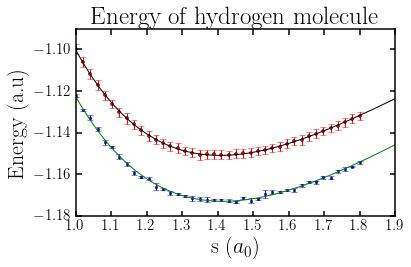

In [32]:
s_vec = np.linspace(1,1.8, 40)
fit_vec = np.linspace(1, 1.9, 100)

#VMC
VMC_E = np.load('.\Data\VMC\E_final.npy')
VMC_Var = np.load('.\Data\VMC\Var_final.npy')
plt.errorbar(s_vec,VMC_E,VMC_Var, fmt = 'ro', markersize=3)

#Fit Morse potential
VMC_guess = [0.15,1.4,np.sqrt(0.385/(2*0.17))]
VMC_parameters, VMC_error = optimize.curve_fit(morse_potential,s_vec,VMC_E,
                                               p0 = VMC_guess, sigma = VMC_Var)

#plot best fit, print uncertainties in estimates
plt.plot(fit_vec,morse_potential(fit_vec,VMC_parameters[0],VMC_parameters[1],
                               VMC_parameters[2]), 'k')
print('best fit parameters VMC', VMC_parameters)
print('uncertainties best fit VMC', np.sqrt(np.diag(VMC_error)))

#DMC
DMC_E = np.load('.\Data\DMC\E_final_combined.npy')
DMC_Var = np.load('.\Data\DMC\Var_final_combined.npy')
plt.errorbar(s_vec,DMC_E,DMC_Var, fmt = 's', markersize=2)

#Fit Morse potential
DMC_guess = [0.17,1.4,np.sqrt(0.385/(2*0.17))]
DMC_parameters, DMC_error = optimize.curve_fit(morse_potential,s_vec,DMC_E, 
                                               p0 = DMC_guess, sigma = DMC_Var)

#plot best fit , print uncertainties in estimates
plt.plot(fit_vec,morse_potential(fit_vec,DMC_parameters[0],DMC_parameters[1],
                                 DMC_parameters[2]))
print('best fit parameters DMC', DMC_parameters)
print('uncertainties best fit DMC', np.sqrt(np.diag(DMC_error)))

#General Layout
plt.title('Energy of hydrogen molecule', fontweight = 'bold')
plt.xlabel(r's ($a_0$)')
plt.ylabel('Energy (a.u)')

plt.savefig('.\Verslag\img\overviewfig.pdf')